In [1]:
!nvidia-smi

Thu Jul 25 10:21:41 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   61C    P8              10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [2]:
import os
HOME = os.getcwd()
print(HOME)

/content


In [3]:
!pip install -q git+https://github.com/THU-MIG/yolov10.git

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 25.3 MB/s eta 0:00:00


In [4]:
!pip install -q supervision roboflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.7/135.7 kB 11.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.7/76.7 kB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.7/178.7 kB 14.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 4.0 MB/s eta 0:00:00


In [5]:
!mkdir -p {HOME}/weights
!wget -P {HOME}/weights -q https://github.com/THU-MIG/yolov10/releases/download/v1.1/yolov10n.pt
!wget -P {HOME}/weights -q https://github.com/THU-MIG/yolov10/releases/download/v1.1/yolov10s.pt
!ls -lh {HOME}/weights

total 43M
-rw-r--r-- 1 root root 11M May 26 15:54 yolov10n.pt
-rw-r--r-- 1 root root 32M May 26 15:54 yolov10s.pt


get the data

In [6]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# Specify the file ID of the ZIP file
file_id = '1gpPX89Qben2lV71LaapMW6pynN9M6YFp'  # Get this ID from the shared link of the zip file
url = "https://drive.google.com/file/d/1gpPX89Qben2lV71LaapMW6pynN9M6YFp/view?usp=sharing"
# Create the PyDrive file instance
downloaded = drive.CreateFile({'id': file_id})

# Download the ZIP file to Colab
downloaded.GetContentFile('data.zip')  # Change to the name you want to save

In [7]:
import zipfile

with zipfile.ZipFile('/content/data.zip', 'r') as zip_ref:
    zip_ref.extractall('data')

# Ultralytics YOLO 🚀, AGPL-3.0 license
# VisDrone2019-DET dataset https://github.com/VisDrone/VisDrone-Dataset by Tianjin University
# Documentation: https://docs.ultralytics.com/datasets/detect/visdrone/
# Example usage: yolo train data=VisDrone.yaml
# parent
# ├── ultralytics
# └── data
#     └── VisDrone  ← downloads here (2.3 GB)

# Train/val/test sets as 1) dir: path/to/imgs, 2) file: path/to/imgs.txt, or 3) list: [path/to/imgs1, path/to/imgs2, ..]
path: /content/data # dataset root dir
train: VisDrone2019-DET-train/images # train images (relative to 'path')  6471 images
val: VisDrone2019-DET-val/images # val images (relative to 'path')  548 images
test: VisDrone2019-DET-test-dev/images # test images (optional)  1610 images

# Classes
names:
  0: pedestrian
  1: people
  2: bicycle
  3: car
  4: van
  5: truck
  6: tricycle
  7: awning-tricycle
  8: bus
  9: motor


names:\
 0: person\
 1: vehicle

train2: epcohs=10 bs=16

train3: epochs=100 bs= 32

In [16]:
!yolo task=detect mode=train epochs=100 batch=32 plots=True \
model={HOME}/weights/yolov10n.pt \
data=/content/VisDrone.yaml

New https://pypi.org/project/ultralytics/8.2.64 available 😃 Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.1.34 🚀 Python-3.10.12 torch-2.3.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=/content/weights/yolov10n.pt, data=/content/VisDrone.yaml, epochs=100, time=None, patience=100, batch=32, imgsz=640, save=True, save_period=-1, val_period=1, cache=False, device=None, workers=8, project=None, name=train5, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, e

In [10]:
import cv2
import supervision as sv
from ultralytics import YOLOv10

model = YOLOv10(f'{HOME}/runs/detect/train5/weights/best.pt')

dataset = sv.DetectionDataset.from_yolo(
    images_directory_path="/content/data/VisDrone2019-DET-test-dev/images",
    annotations_directory_path="/content/data/VisDrone2019-DET-test-dev/labels",
    data_yaml_path="/content/VisDrone.yaml"
)

bounding_box_annotator = sv.BoxAnnotator()
label_annotator = sv.LabelAnnotator()

SupervisionWarnings: images is deprecated: `DetectionDataset.images` property is deprecated and will be removed in `supervision-0.26.0`. Iterate with `for path, image, annotation in dataset:` instead.
SupervisionWarnings: images is deprecated: `DetectionDataset.images` property is deprecated and will be removed in `supervision-0.26.0`. Iterate with `for path, image, annotation in dataset:` instead.



0: 384x640 6 persons, 15 vehicles, 11.6ms
Speed: 3.6ms preprocess, 11.6ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


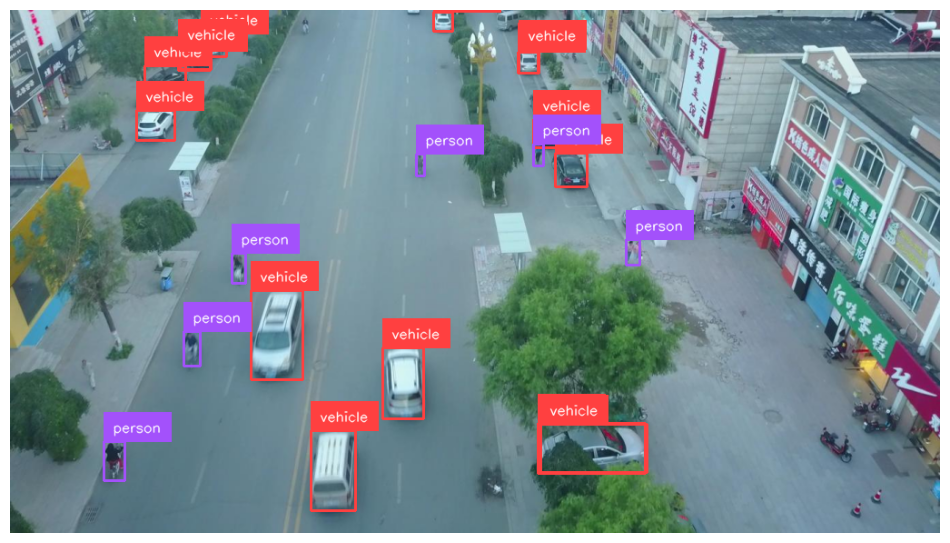

In [12]:
import random

random_image = random.choice(list(dataset.images.keys()))
random_image = dataset.images[random_image]
# Calculate the scaling factor
scaling_factor = min(1024 / random_image.shape[1], 1024 / random_image.shape[0])

# Resize the image while maintaining aspect ratio
new_size = (int(random_image.shape[1] * scaling_factor), int(random_image.shape[0] * scaling_factor))
random_image = cv2.resize(random_image,new_size,interpolation = cv2.INTER_AREA)
results = model(source=random_image, conf=0.25)[0]
detections = sv.Detections.from_ultralytics(results)

annotated_image = bounding_box_annotator.annotate(
    scene=random_image, detections=detections)
annotated_image = label_annotator.annotate(
    scene=annotated_image, detections=detections)

sv.plot_image(annotated_image)

In [17]:
import shutil
from google.colab import files

run_dir = "/content/runs"
zip_file = "/content/yolov10n_bs32_epoch100_custom_label"

shutil.make_archive(zip_file, "zip", run_dir)

files.download('/content/yolov10n_bs32_epoch100_custom_label.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>